In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import os
import psutil
from torchviz import make_dot  # For visualizing model architecture
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image

# 1. Set up device for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:

# Data transformations for MRI brain tumor scans
transform = {
    'train': transforms.Compose([
        transforms.Resize(256),                # Standardize input size for easier model handling
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Cropping out slight zoom-in variation
        transforms.RandomAffine(degrees=15, translate=(0.1, 0.1)),  # Mild rotation and translation
        transforms.ColorJitter(brightness=0.1, contrast=0.1),  # Minor brightness & contrast adjustments
        transforms.RandomHorizontalFlip(p=0.5),  # Horizontal flip, if justified for your dataset
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}


# 3. Load datasets
data_dir = r"C:\Users\bhuva\Desktop\brain_CT\split_data"  # Define path to your dataset
batch_size = 32
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform['train'])
val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform['val'])
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=transform['val'])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



In [3]:
# 4. Define model with pretrained weights and adjust final layer
model = models.resnet50(weights='IMAGENET1K_V1')
model.fc = nn.Linear(model.fc.in_features, 4)  # Set number of classes
model = model.to(device)

# Visualize model architecture
x = torch.randn(1, 3, 224, 224).to(device)
make_dot(model(x), params=dict(model.named_parameters())).render("brain_tumor_model", format="png")

# 5. Set training parameters
num_epochs = 3
criterion = nn.CrossEntropyLoss()
learning_rate = 1e-4
weight_decay = 1e-5
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
early_stopping_patience = 5



c:\Users\bhuva\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [4]:
# 6. Initialize logging for training metrics
train_log = []
best_val_loss = np.inf
patience_counter = 0

# 7. Training loop with progress bar and logging
for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    epoch_start_time = time.time()
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")

    for images, labels in train_pbar:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total
    val_loss, val_acc = 0.0, 0.0

    # Validation
    model.eval()
    with torch.no_grad():
        correct, total = 0, 0
        val_running_loss = 0.0
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            
        val_loss = val_running_loss / total
        val_acc = correct / total

    scheduler.step(val_loss)

    # Document metrics
    epoch_time = time.time() - epoch_start_time
    mem_usage = psutil.Process(os.getpid()).memory_info().rss / (1024 * 1024)  # Memory in MB
    train_log.append({
        'epoch': epoch + 1, 'train_loss': train_loss, 'train_acc': train_acc, 
        'val_loss': val_loss, 'val_acc': val_acc, 'epoch_time': epoch_time, 'memory_usage_mb': mem_usage
    })

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'brain.pth')
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print("Early stopping triggered.")
            break

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Time: {epoch_time:.2f}s")

# Save logs to CSV
pd.DataFrame(train_log).to_csv("training_log_brain.csv", index=False)



Epoch 1/3: 100%|██████████| 176/176 [02:07<00:00,  1.38batch/s]


Epoch 1/3 - Train Loss: 0.2633, Train Acc: 0.9060, Val Loss: 0.1088, Val Acc: 0.9629, Time: 133.72s


Epoch 2/3: 100%|██████████| 176/176 [02:04<00:00,  1.42batch/s]


Epoch 2/3 - Train Loss: 0.1121, Train Acc: 0.9623, Val Loss: 0.0755, Val Acc: 0.9757, Time: 130.07s


Epoch 3/3: 100%|██████████| 176/176 [02:03<00:00,  1.42batch/s]


Epoch 3/3 - Train Loss: 0.0800, Train Acc: 0.9715, Val Loss: 0.0693, Val Acc: 0.9743, Time: 129.73s


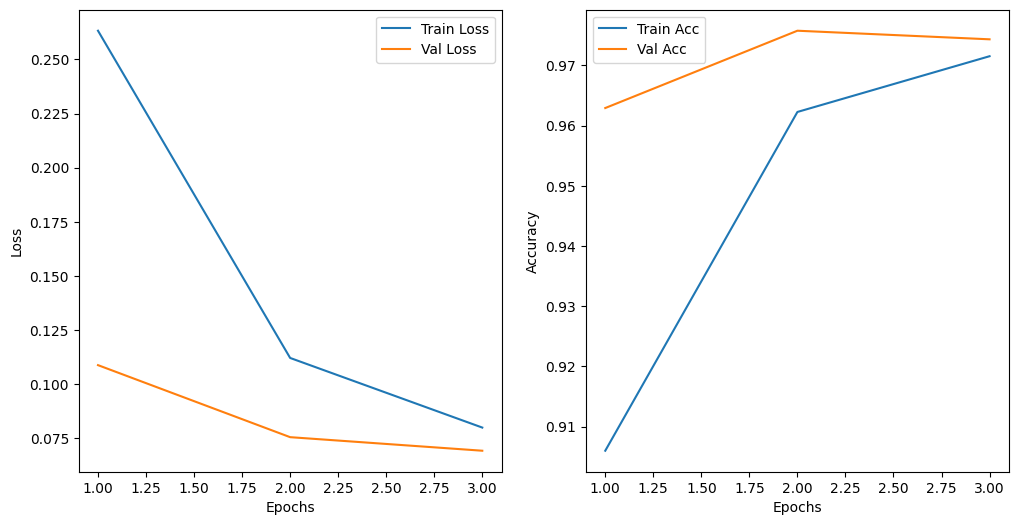

In [5]:
# 8. Plot training history
history_df = pd.DataFrame(train_log)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_df['epoch'], history_df['train_loss'], label='Train Loss')
plt.plot(history_df['epoch'], history_df['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_df['epoch'], history_df['train_acc'], label='Train Acc')
plt.plot(history_df['epoch'], history_df['val_acc'], label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()





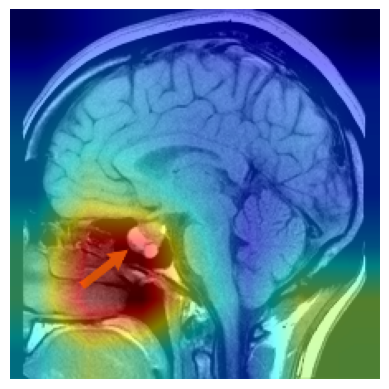

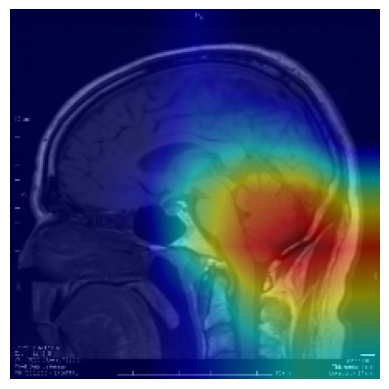

In [14]:
# 9. Grad-CAM Visualization
import cv2
target_layer = model.layer4[-1]
cam = GradCAM(model=model, target_layers=[target_layer])

def plot_gradcam(image_path):
    # Load image and convert to numpy array
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (224, 224))  # Resize to model input size
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

    # Preprocess the image (normalize and convert to tensor)
    img_tensor = preprocess_image(img_rgb, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]).to(device)

    # Run Grad-CAM and obtain the grayscale heatmap
    grayscale_cam = cam(input_tensor=img_tensor)[0, :]  # First item of batch

    # Apply heatmap to original image for visualization
    cam_image = show_cam_on_image(img_rgb / 255.0, grayscale_cam, use_rgb=True)  # Normalize to 0-1 range
    plt.imshow(cam_image)
    plt.axis('off')
    plt.show()

# Example usage of Grad-CAM on a sample image
plot_gradcam(r"C:\Users\bhuva\Downloads\cassie-pituitary.jpg")
plot_gradcam(r"C:\Users\bhuva\Downloads\normal pituitary.jpg")


C:\Users\bhuva\AppData\Local\Temp\ipykernel_14848\1141558416.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('brain.pth'))


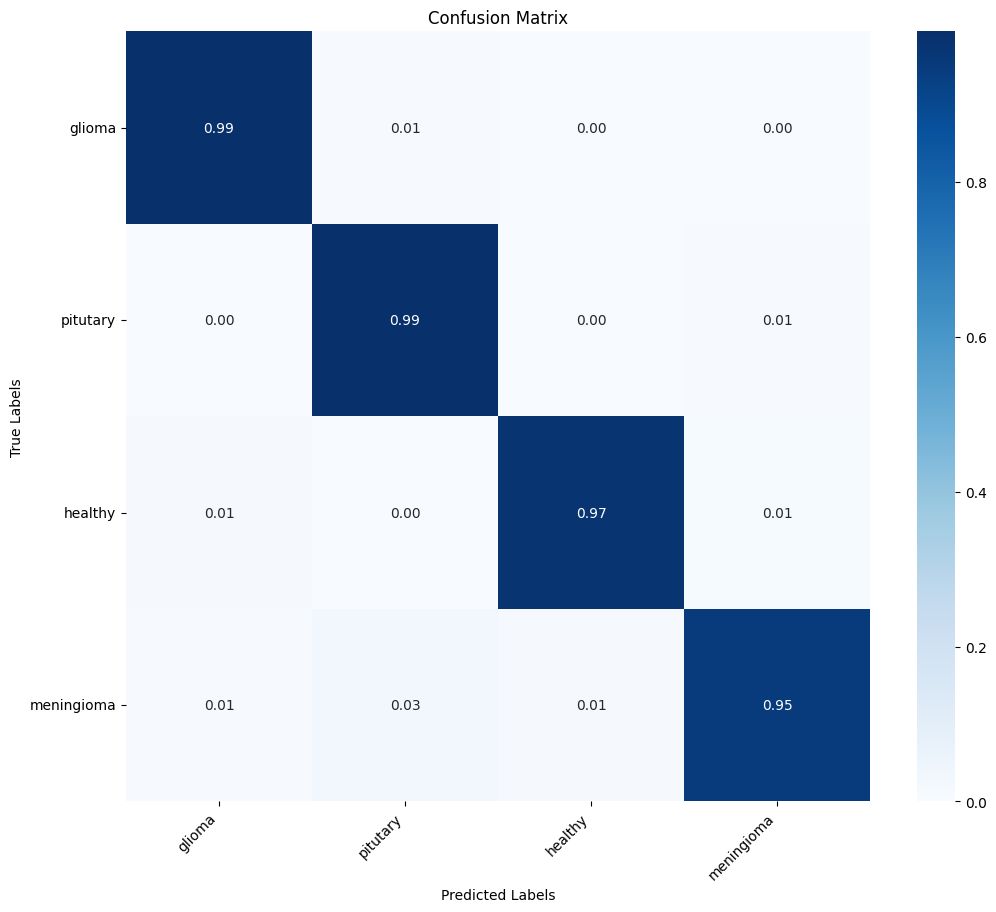

In [12]:
# 10. Evaluate on Test Set
model.load_state_dict(torch.load('brain.pth'))
model.eval()
all_labels, all_preds = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

# Confusion Matrix Plot
class_names = ["glioma","healthy","meningioma","pitutary"]
def plot_confusion_matrix(y_true, y_pred, classes, normalize=True, top_n=None):
    cm = confusion_matrix(y_true, y_pred)
    if top_n:
        misclassified_counts = np.sum(cm, axis=1) - np.diag(cm)
        top_confused_indices = np.argsort(misclassified_counts)[-top_n:]
        cm = cm[top_confused_indices, :][:, top_confused_indices]
        classes = [classes[i] for i in top_confused_indices]
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt=".2f" if normalize else "d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.show()

plot_confusion_matrix(all_labels, all_preds, classes=class_names, normalize=True, top_n=10)

Predicted Class: pituitary


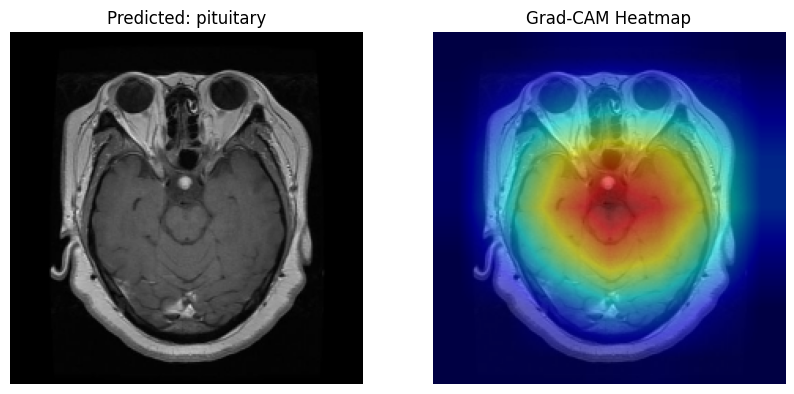

In [23]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image

# Ensure your model and target layer are defined
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)  # Move model to the appropriate device
model.eval()  # Set model to evaluation mode
target_layer = model.layer4[-1]  # Adjust based on your model architecture

# Initialize Grad-CAM
cam = GradCAM(model=model, target_layers=[target_layer])

# Define the classes in the dataset
classes = ["glioma", "healthy", "meningioma", "pituitary"]

# Define the function for classification and Grad-CAM visualization
def classify_and_visualize(image_path):
    # Load and preprocess the image
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (224, 224))  # Resize to model input size
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

    # Preprocess image for the model
    img_tensor = preprocess_image(img_rgb, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]).to(device)

    # Run model inference
    with torch.no_grad():
        output = model(img_tensor)
        _, predicted_idx = torch.max(output, 1)
        predicted_class = classes[predicted_idx]

    # Generate Grad-CAM heatmap
    grayscale_cam = cam(input_tensor=img_tensor)[0, :]  # Grad-CAM heatmap for the first batch element

    # Overlay Grad-CAM on the original image
    cam_image = show_cam_on_image(img_rgb / 255.0, grayscale_cam, use_rgb=True)  # Normalize original image to 0-1

    # Display the classification result and Grad-CAM heatmap
    print(f"Predicted Class: {predicted_class}")
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title(f"Predicted: {predicted_class}")
    plt.imshow(img_rgb)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Grad-CAM Heatmap")
    plt.imshow(cam_image)
    plt.axis('off')
    plt.show()

# Example usage
classify_and_visualize(r"C:\Users\bhuva\Downloads\Te-pi_0010.jpg")
